In [1]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 25
BS = 32

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("./dataset_1/"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(100, 100), color_mode='grayscale')
	# image = load_img(imagePath, target_size=(100, 100), color_mode='grayscale')
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [4]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels[0]

array([0., 1.], dtype=float32)

In [5]:
data[0].shape

(100, 100, 1)

In [6]:
data[0].flatten().shape

(10000,)

In [7]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
# construct the head of the model that will be placed on top of the
# the base model
# headModel = baseModel.output
model_input = Input(shape=(100, 100, 1))
headModel = Conv2D(200, (3,3), activation="relu")(model_input)
headModel = Conv2D(100, (3,3), activation="relu",)(model_input)
headModel = MaxPooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=model_input, outputs=headModel)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 100)       1000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 102400)            0         
_________________________________________________________________
dropout (Dropout)            (None, 102400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6553664   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130   

In [10]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [11]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/25
34/34 [==============================] - 2s 38ms/step - loss: 0.6638 - accuracy: 0.6067 - val_loss: 0.5491 - val_accuracy: 0.7065
Epoch 2/25
34/34 [==============================] - 1s 26ms/step - loss: 0.5563 - accuracy: 0.7060 - val_loss: 0.4921 - val_accuracy: 0.7717
Epoch 3/25
34/34 [==============================] - 1s 26ms/step - loss: 0.5084 - accuracy: 0.7646 - val_loss: 0.4276 - val_accuracy: 0.8080
Epoch 4/25
34/34 [==============================] - 1s 26ms/step - loss: 0.4970 - accuracy: 0.7706 - val_loss: 0.3980 - val_accuracy: 0.8333
Epoch 5/25
34/34 [==============================] - 1s 26ms/step - loss: 0.4891 - accuracy: 0.7681 - val_loss: 0.3855 - val_accuracy: 0.8442
Epoch 6/25
34/34 [==============================] - 1s 27ms/step - loss: 0.4403 - accuracy: 0.8047 - val_loss: 0.4020 - val_accuracy: 0.8261
Epoch 7/25
34/34 [==============================] - 1s 27ms/step - loss: 0.4800 - accuracy: 0.7656 - val_loss: 0.3526 - val_accura

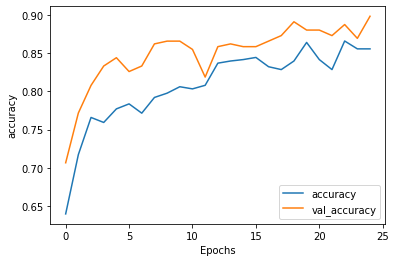

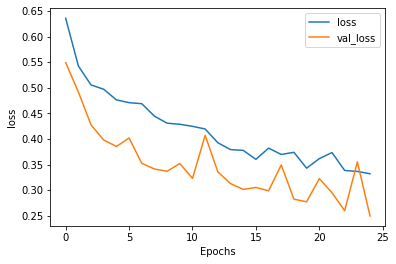

In [12]:
from matplotlib import pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(H, "accuracy")
plot_graphs(H, "loss")

In [13]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
                          precision    recall  f1-score   support

   ./dataset_1/with_mask       0.90      0.90      0.90       138
./dataset_1/without_mask       0.90      0.90      0.90       138

                accuracy                           0.90       276
               macro avg       0.90      0.90      0.90       276
            weighted avg       0.90      0.90      0.90       276



In [14]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("trained_model_1.h5", save_format="h5")

[INFO] saving mask detector model...
